https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

# Topic Modeling with BERT
### Leveraging BERT and TF-IDF to create easily interpretable topics.

Maarten Grootendorst

Towards Data Science

Oct 5, 2020

Often when I am approached by a product owner to do some NLP-based analyses, I am typically asked the following question:

    `‘Which topic can frequently be found in these documents?’`

Void of any categories or labels I am forced to look into unsupervised techniques to extract these topics, namely Topic Modeling.

Although topic models such as LDA and NMF have shown to be good starting points, I always felt it took quite some effort through hyperparameter tuning to create meaningful topics.

Moreover, I wanted to use transformer-based models such as BERT as they have shown amazing results in various NLP tasks over the last few years. Pre-trained models are especially helpful as they are supposed to contain more accurate representations of words and sentences.

A few weeks ago I saw this great project named Top2Vec* which leveraged document- and word embeddings to create topics that were easily interpretable. I started looking at the code to generalize Top2Vec such that it could be used with pre-trained transformer models.

The great advantage of Doc2Vec is that the resulting document- and word embeddings are jointly embedding in the same space which allows document embeddings to be represented by nearby word embeddings. Unfortunately, this proved to be difficult as BERT embeddings are token-based and do not necessarily occupy the same space**.

Instead, I decided to come up with a different algorithm that could use BERT and 🤗 transformers embeddings. The result is BERTopic, an algorithm for generating topics using state-of-the-art embeddings.

The main topic of this article will not be the use of BERTopic but a tutorial on how to use BERT to create your own topic model.

PAPER*: Angelov, D. (2020). Top2Vec: Distributed Representations of Topics. arXiv preprint arXiv:2008.09470.

NOTE**: Although you could have them occupy the same space, the resulting size of the word embeddings is quite large due to the contextual nature of BERT. Moreover, there is a chance that the resulting sentence- or document embeddings will degrade in quality.

## 1. Data & Packages

For this example, we use the famous 20 Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics. Using Scikit-Learn, we can quickly download and prepare the data:

In [1]:
from sklearn.datasets import fetch_20newsgroups
import re
from pathlib import Path
import pandas as pd

## 1b. Importing Text Data

In [2]:
# practice data that comes with Scikit-Learn
"""
alldata = fetch_20newsgroups(subset='all')
data = alldata['data']
file_topics = [re.match(".+\\\\(.+)\\\\.*", fn).group(1) for fn in alldata['filenames']]
len(file_topics)
"""

'\nalldata = fetch_20newsgroups(subset=\'all\')\ndata = alldata[\'data\']\nfile_topics = [re.match(".+\\\\(.+)\\\\.*", fn).group(1) for fn in alldata[\'filenames\']]\nlen(file_topics)\n'

In [3]:
# NYT metadata
textdir = Path("~/shared/RR-workshop-data/text_datasets").expanduser()
textdf = pd.read_csv(Path(textdir, "nyt_df_2023-10.csv"), encoding = 'utf-8')
cols_to_concat = ['news_desk', "section_name", "subsection_name", "type_of_material"]
file_topics = textdf[cols_to_concat].apply(lambda row: '.'.join(row.values.astype(str)), axis = 1).tolist()
textdf['abstract'] = textdf['abstract'].fillna("")
data = textdf['abstract'].tolist()

In [4]:
# SOTU dataset
"""
textdir = Path("~/shared/RR-workshop-data/state-of-the-union-dataset").expanduser()
textdf = pd.read_csv(Path(textdir, "sotudf.tsv"), encoding = 'utf-8', sep = "\t")
cols_to_concat = ["president", "year"]
file_topics = textdf[cols_to_concat].apply(lambda row: '.'.join(row.values.astype(str)), axis = 1).tolist()
data = textdf['text'].tolist()
"""

'\ntextdir = Path("~/shared/RR-workshop-data/state-of-the-union-dataset").expanduser()\ntextdf = pd.read_csv(Path(textdir, "sotudf.tsv"), encoding = \'utf-8\', sep = "\t")\ncols_to_concat = ["president", "year"]\nfile_topics = textdf[cols_to_concat].apply(lambda row: \'.\'.join(row.values.astype(str)), axis = 1).tolist()\ndata = textdf[\'text\'].tolist()\n'

## 1c. Review our data

In [5]:
data[:10]

['The new chairman of the Senate Foreign Relations Committee could force the Biden administration to reverse its decision to send Egypt $235 million in military assistance.',
 'The Senate overwhelmingly passed a bill to fund the federal government through mid-November. See how each senator voted.',
 'In much of Europe, the election in Slovakia was seen as a bellwether of mainstream support for Ukraine in its war with Russia. But voters seemed most concerned with pocketbook issues.',
 'Gideon Cody, who orchestrated a widely criticized raid on The Marion County Record, was suspended indefinitely, a city official said on Saturday.',
 'The assistant general manager of the Calgary Flames, he was given a year to live in 2019. He and his wife used the time to document life with the disease.',
 'The move marks a loss for the state labor federation and disappointed union leaders who had hoped to capitalize on a wave of high-profile strikes in the state.',
 'No corrections appeared in print on S

In [6]:
file_topics[:10]

['Washington.U.S..Politics.News',
 'Graphics.U.S..Politics.Interactive Feature',
 'Foreign.World.Europe.News',
 'Express.U.S..nan.News',
 'Sports.Sports.nan.Obituary (Obit)',
 'National.U.S..nan.News',
 'Corrections.Corrections.nan.News',
 'Summary.Corrections.nan.Quote',
 'Politics.U.S..Politics.News',
 'Games.Crosswords & Games.nan.News']

In [7]:
#alldata = fetch_20newsgroups(subset='all')
#alldata.keys()


If you want to speed up training, you can select the subset train as it will decrease the number of posts you extract.

**NOTE:** If you want to apply topic modeling not on the entire document but on the paragraph level, I would suggest splitting your data before creating the embeddings.

In [8]:
print(len(data))
#if len(data) > 2000:
#   data = data.sample(n = 1000)

3906


## 2. Embeddings

The very first step we have to do is converting the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word. Not only that, there are many pre-trained models available ready to be used.

How you generate the BERT embeddings for a document is up to you. However, I prefer to use the sentence-transformers package as the resulting embeddings have shown to be of high quality and typically work quite well for document-level embeddings.

Install the package with pip install sentence-transformers before generating the document embeddings. If you run into issues installing this package, then it is worth installing Pytorch first.

Then, run the following code to transform your documents in 512-dimensional vectors:

*Note: Running this on all 18,000 news articles in the dataset took 9 minutes on my laptop with 32 GB Ram. If you don't want to wait so long either select `subset = "train"` in Step 1 or extract a random sample of the dataset (as commented out in the code cell above).

In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

c:\Users\F0040RP\Documents\DartLib_RDS\pythoncode\computational-text-analysis-week\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 123/123 [00:42<00:00,  2.88it/s]


In [10]:
len(embeddings)

3906

We are using Distilbert as it gives a nice balance between speed and performance. The package has several multi-lingual models available for you to use.

NOTE: Since transformer models have a token limit, you might run into some errors when inputting large documents. In that case, you could consider splitting documents into paragraphs.

## 3. Clustering

We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

#### UMAP

Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

Install the package with `pip install umap-learn` before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [11]:
#import umap
import umap.umap_ as umap    #with pip install umap-learn
neighbornum = 15  #15
comp_num = 5   #5
umap_embeddings = umap.UMAP(n_neighbors=neighbornum,                         
                            n_components=comp_num, 
                            metric='cosine').fit_transform(embeddings)

### HDBSCAN

After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

Install the package with `pip install hdbscan`\* then create the clusters:

\* *Note: I encountered an error when first trying to install hdbscan. I resolved it by following a suggestion in the error message to install a newer version of Microsoft Visual C++ (>14.0)*

In [12]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,   # default 15 works good for newsgroup dataset; 5 works better for NYT dataset
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Great! We now have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

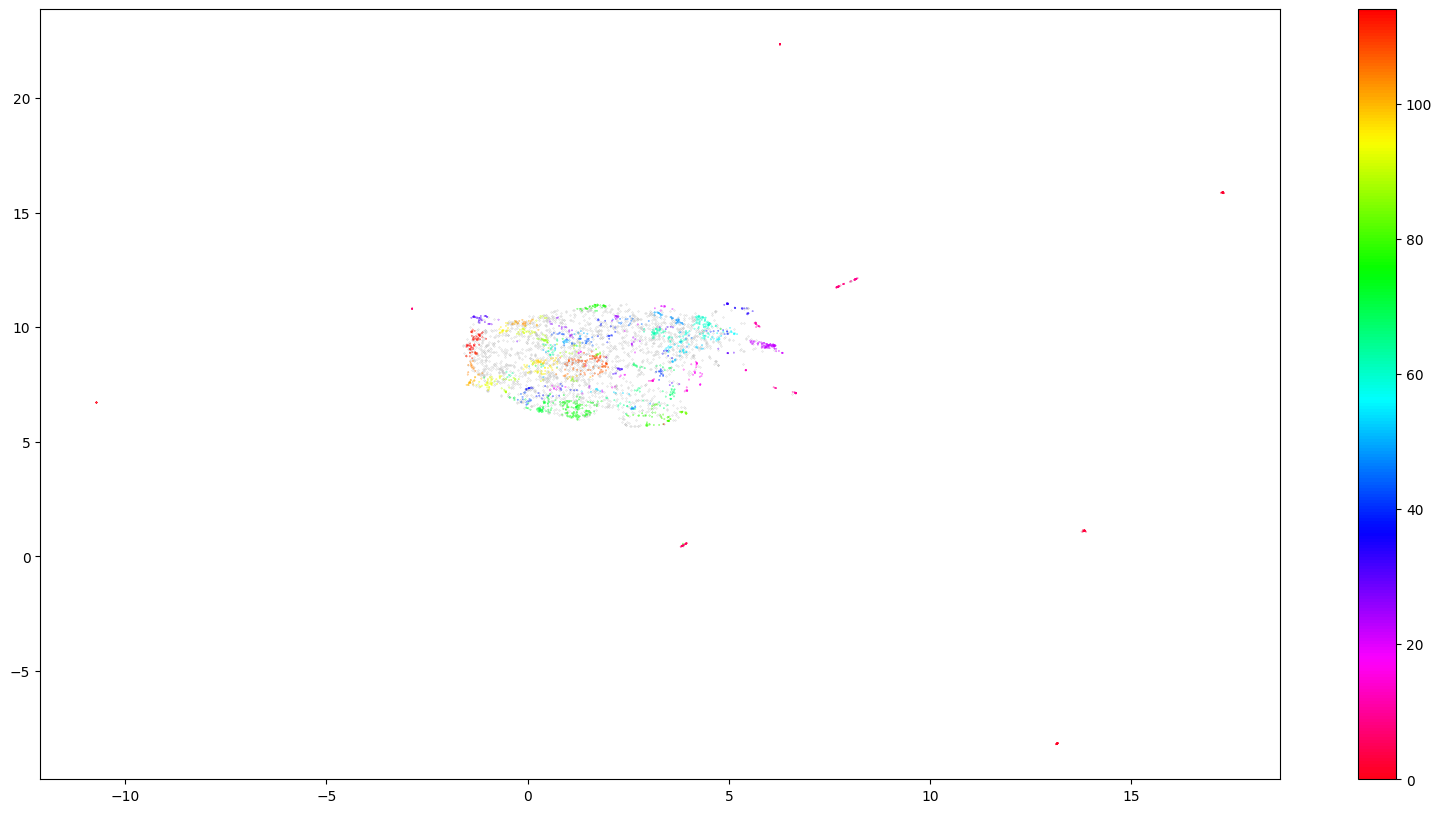

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)   #for nyt: n_neighbors = 15, n_components = 2
result = pd.DataFrame(umap_data, columns=['x', 'y'])

result['filetopics'] = file_topics  ###

result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [14]:
clustered['labels'].value_counts()

labels
75    84
22    82
60    64
62    40
71    38
      ..
64     5
27     5
90     5
30     5
23     5
Name: count, Length: 115, dtype: int64

It is difficult to visualize the individual clusters due to the number of topics generated (~55). However, we can see that even in 2-dimensional space some local structure is kept.

NOTE: You could skip the dimensionality reduction step if you use a clustering algorithm that can handle high dimensionality like a cosine-based k-Means.

In [15]:
result['datatype'] = "cluster"
result.loc[(result['labels'] == -1),'datatype'] = "outlier"

import plotly.express as px
#fig = px.scatter(x = outliers.x, y = outliers.y, size_max = 0.03, color_discrete_sequence=['rgba(50, 50, 50, 0.5)']) #color='#BDBDBD',  
#fig = px.scatter(x = clustered.x, y = clustered.y, size_max=0.06, hover_name = clustered.filetopics, color = clustered.labels) #color_discrete_sequence=['blue'])   #cmap='hsv_r',
fig = px.scatter(result, x = "x", y = "y", size_max = 0.05, hover_name = "filetopics", color = "labels", facet_col = "datatype", facet_col_wrap=1)
fig.update_layout(
    height = 1500,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(opacity = 0.5)
fig.show()

In [16]:
clustered.head()

,x,y,filetopics,labels
6,-2.870897,10.809326,Corrections.Corrections.nan.News,7
8,1.709609,8.727884,Politics.U.S..Politics.News,108
9,13.152866,-8.178088,Games.Crosswords & Games.nan.News,1
11,5.126096,9.711042,Metropolitan.New York.nan.News,56
12,3.121049,7.679379,RealEstate.Real Estate.nan.News,14


In [17]:
#subplots with plotly
## StackOverflow about overlaying two different plots (using plotly graph objects as plotly express does not seem to support this):
### https://stackoverflow.com/questions/62287001/how-to-overlay-two-plots-in-same-figure-in-plotly-create-pareto-chart-in-plotl


from plotly.subplots import make_subplots
import plotly.graph_objects as go

trace1 = go.Scatter(
    #data = clustered
    x = clustered['x'],
    y = clustered['y'],
    mode = 'markers', 
    
    marker = dict(color = clustered['labels'], size = 6, opacity = 0.8),
    hovertext = clustered['filetopics'],
)

trace2 = go.Scatter(
    #data = outliers,
    x = outliers['x'],
    y = outliers['y'],
    mode = 'markers',
    marker = dict(color = "gray", opacity = 0.5, size = 3),
    hoverinfo='skip'
    #hovertext = outliers['filetopics']

)

fig = make_subplots()
fig.add_trace(trace2)
fig.add_trace(trace1)


fig['layout'].update(height = 800, width = 1200, title = "graph", xaxis=dict(
      tickangle=-90
    ), yaxis_range=[-3,15], xaxis_range = [0, 20]
    )

fig.show()




## 4. Topic Creation

What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?

    How can we derive topics from clustered documents?

To solve this, I came up with a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

#### c-TF-IDF

To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [18]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Then, we apply the class-based TF-IDF:
class-based TF-IDF by joining documents within a class. 

Image by the author.

Where the frequency of each word t is extracted for each class i and divided by the total number of words w. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents m is divided by the total frequency of word t across all classes n.

In [19]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

#### Topic Representation

In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [20]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)


We can use `topic_sizes` to view how frequent certain topics are:

In [21]:
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,2082
76,75,84
23,22,82
61,60,64
63,62,40
72,71,38
94,93,37
109,108,37
4,3,37
2,1,36


We can use `topic_sizes` to view how frequent certain topics are:

In [22]:
top_n_words[72][:10]

[('fewer', 0.07135976938078123),
 ('dystopian', 0.07135976938078123),
 ('satire', 0.07135976938078123),
 ('cars', 0.05843158048396272),
 ('comedy', 0.05843158048396272),
 ('drug', 0.05676935078582176),
 ('theater', 0.05470328745469495),
 ('prices', 0.05153459361271948),
 ('growing', 0.05153459361271948),
 ('city', 0.04915724431367239)]

Looking at the largest four topics, I would say that these nicely seem to represent easily interpretable topics!

I can see sports, computers, space, and religion as clear topics that were extracted from the data.

## 5. Topic Reduction

There is a chance that, depending on the dataset, you will get hundreds of topics that were created! You can tweak the parameters of HDBSCAN such that you will get fewer topics through its min_cluster_size parameter but it does not allow you to specify the exact number of clusters.

A nifty trick that Top2Vec was using is the ability to reduce the number of topics by merging the topic vectors that were most similar to each other.

We can use a similar technique by comparing the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics:

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,2131
62,61,91
19,18,82
50,49,64
52,51,40
59,58,38
78,77,37
90,89,37
3,2,37
1,0,36


In [24]:
top_n_words[58][:10]

[('america', 0.05992734660826237),
 ('dangerous', 0.05189611595055106),
 ('inhumane', 0.048727472224287326),
 ('tribalism', 0.048727472224287326),
 ('tragedy', 0.04611997956764318),
 ('middle', 0.04604914678427791),
 ('east', 0.04548155353646827),
 ('norms', 0.04426993408563816),
 ('political', 0.04372282469279669),
 ('christian', 0.03981239594698899)]

Above, we took the least common topic and merged it with the most similar topic. By repeating this 19 more times we reduced the number of topics from 56 to 36!

NOTE: We can skip the re-calculation part of this pipeline to speed up the topic reduction step. However, it is more accurate to re-calculate the c-TF-IDF vectors as that would better represent the newly generated content of the topics. You can play around with this by, for example, update every n steps to both speed-up the process and still have good topic representations.

TIP: You can use the method described in this article (or simply use BERTopic) to also create sentence-level embeddings. The main advantage of this is the possibility to view the distribution of topics within a single document.
Thank you for reading!

If you are, like me, passionate about AI, Data Science, or Psychology, please feel free to add me on LinkedIn or follow me on Twitter.